## Контрольная работа CVDL, 17.10.23
Вам необходимо обучить многоклассовый классификатор изображений на train части датасета, находящегося в DATASET_PATH.
Также надо проверить что обучение сошлось, и замерять метрики на test.

Баллы:
 - работающий код тренировки с правильным лоссом и головой для задачи многоклассовой классификации: **4** балла
 - метрики precision/recall по классам по train и test: **2** балла
 - график train и test лоссов: **2** балла
 - отсутствие оверфита по графикам train-test (т.е кратной разницы лоссов и метрик): **1** балл
 - precision и recall (c average='macro') - на test оба выше 0.7: **1** балл
 
Предполагается, что вы используете предобученную модель и затюните ее. Датасеты train и тест маленькие, всего по  2500 изображений, так что обучение сети с нуля приведет к оверфиту.

In [1]:
from pathlib import Path

#######
DATASET_PATH = '<SET PATH HERE>'
#######

DATASET_PATH = Path(DATASET_PATH)
assert DATASET_PATH.exists()

In [7]:
import pandas

In [8]:
import torch
import numpy as np
from tqdm import tqdm

In [9]:
from torchvision.datasets.folder import DatasetFolder, default_loader
from typing import Optional, Callable, Tuple, Any, List
import pandas as pd


class FoodDataset(DatasetFolder):    
    def __init__(self,
            root: str,
            classes_path: str,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
            ):
        super().__init__(root=root, transform=transform, loader=default_loader, target_transform=target_transform, extensions='')
        self.root = Path(root)
        self._image_paths = self.find_images_recursively(self.root)
        self._classes_map = pd.read_csv(classes_path).set_index('Class Name (str)')['Coarse Class Name (str)']
        self._image_labels = [self.determine_sample_label(self.root, ip) for ip in self._image_paths]
        self.classes = list(dict.fromkeys(self._classes_map))
        self.samples = [
            (sample_path, self.classes.index(sample_cls))
            for (sample_path, sample_cls) in zip(self._image_paths, self._image_labels)
        ]
    
    def find_images_recursively(self, root_path):
        files = list(root_path.glob("[!.]*"))
        samples = list(f for f in files if not f.is_dir())
        subdirs = list(f for f in files if f.is_dir())
        assert len(samples) == 0 or len(subdirs) == 0, f"Can't mix subdirs and images"
        if len(subdirs):
            samples = []
            for sub_root_path in subdirs:
                samples += self.find_images_recursively(sub_root_path)
        return samples
    
    def determine_sample_label(self, root_path, sample_path):
        parts = sample_path.relative_to(root_path).parent.parts
        precise_label = parts[-1]
        coarse_label = self._classes_map[precise_label]
        return coarse_label

In [10]:
ds_train = FoodDataset(DATASET_PATH / 'train', DATASET_PATH / 'classes.csv')
ds_test = FoodDataset(DATASET_PATH / 'test', DATASET_PATH / 'classes.csv')
print(len(ds_train), len(ds_test))

2640 2485


In [11]:
ds_train.classes == ds_test.classes

True

Orange


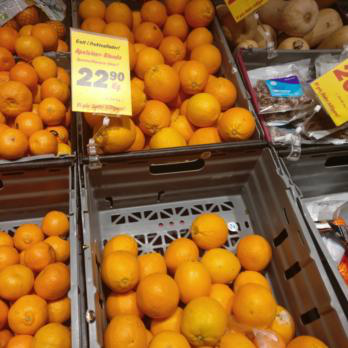

In [12]:
img, cls_idx = ds_train[750]
print(ds_train.classes[cls_idx])
img

### Подготовка к тренировке

In [7]:
N_CLASSES = len(ds_train.classes)

In [8]:
import torchvision.transforms as transforms

In [11]:
def target_transform(x):
    return torch.Tensor([x]).long()[0]

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        transforms.Resize((224, 224)),
    ]
)


Трансформы можно менять - например, можно добавить аугментации

In [12]:
train_transform = test_transform


In [14]:
ds_train = FoodDataset(DATASET_PATH / 'train', DATASET_PATH / 'classes.csv', transform=train_transform, target_transform=target_transform)
ds_test = FoodDataset(DATASET_PATH / 'test', DATASET_PATH / 'classes.csv', transform=test_transform, target_transform=target_transform)

In [15]:
BATCH_SIZE = 32
NUM_WORKERS = 0

trainloader = torch.utils.data.DataLoader(
    ds_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
)
testloader = torch.utils.data.DataLoader(
    ds_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

### Построение модели
Используйте не слишком тяжелую pretrained-модель, заморозьте ее и добавьте голову на N классов.

Важно помнить, что для некоторых слоев поведение в train/eval режимах - разное, и от этого зависит "успешность" тюнинга.

In [3]:
backbone = None
head = None

In [20]:
net = torch.nn.Sequential(backbone, head)

## Лосс

In [2]:
criterion = None

## Тренировка

Для легкого backbone с замороженными весами на batch=32 скорость train ~ 10 батчей в секунду, а в эпохе ~ 80 батчей.

Тренировка в 50 эпох займет 80batch / 10batch/s * 50ep * 2 \[train + test\] = 800s ~13min 

In [4]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [5]:
def run_1_epoch(net, optimizer, dataloader, criterion, *, device=None):
    return loss_logs, metrics

In [24]:
#!g2.mig
gpu = torch.device('cuda')
net = net.to(gpu)
opt = torch.optim.Adam(net.parameters(), lr=3e-5)

In [6]:
train_logs = []
train_metrics = []
val_logs = []
val_metrics = []

In [5]:
#!g2.mig
# do something

## Метрики и лосс

In [29]:
print(f"Train Precision/Recall: {train_metrics[-2:]}, \nTest Precision/Recall {val_metrics[-2:]}")

Train Precision/Recall: [0.7793789337004585, 0.6871259750712141], 
Test Precision/Recall [0.6445287578083437, 0.552591486302335]


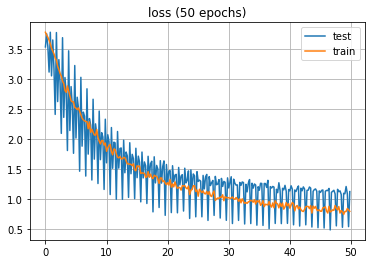

In [30]:
from matplotlib import pyplot as plt
epochs = np.arange(0, 50, 0.2)
plt.plot(epochs, val_logs, label='test')
plt.plot(epochs, train_logs, label='train')

plt.title('loss (50 epochs)')
plt.grid()
plt.legend()


### Окружение
Список пакетов в python виртуальной машины

In [9]:
! cat /etc/lsb-release

DISTRIB_ID=Ubuntu
DISTRIB_RELEASE=18.04
DISTRIB_CODENAME=bionic
DISTRIB_DESCRIPTION="Ubuntu 18.04.6 LTS"


In [1]:
! python -V

Python 3.10.12


In [2]:
! pip list

Package                       Version      Editable project location
----------------------------- ------------ ----------------------------------------------------------
a4_course_cvdl_t1             0.2.0        D:\edu\course_cvdl\task1
a4_course_cvdl_t2             0.2.0        D:\edu\course_cvdl\task2
abbyy-course-cvdl-t1          0.1.0
about-time                    4.2.1
absl-py                       1.4.0
addict                        2.4.0
aiohttp                       3.8.5
aiohttp-retry                 2.8.3
aiosignal                     1.3.1
alabaster                     0.7.13
albumentations                1.3.1
alembic                       1.12.0
alive-progress                3.1.4
amqp                          5.1.1
annotated-types               0.5.0
antlr4-python3-runtime        4.9.3
anyio                         3.7.1
appdirs                       1.4.4
argcomplete                   3.1.1
argon2-cffi                   23.1.0
argon2-cffi-bindings          21.2.0
arrow